In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from transformers import TFBertForSequenceClassification, BertTokenizer

import matplotlib.pyplot as plt

### Training data, label ID's and model read

In [27]:
training_data = [
    {'text' : 'How is my financial health?', 'label': 'analyze_finances'},      # balance and financial tips
    {'text' : 'What is my balance?', 'label': 'check_balance'},
    {'text' : 'Give me tips to helpe me save up money', 'label': 'financial_tips'},

    {'text' : 'How can I open a new account?', 'label': 'open_account'},        # account management
    {'text' : 'Can I close my savings?', 'label' : 'close_account'},
    { 'text' : 'How do I update my contact information?', 'label' : 'update_account_info' },
    { 'text' : 'I want to change my account type.', 'label' : 'change_account_type' }
]


label_to_id = {
    'analyze_finances' : 0,          # balance and financial tips
    'check_balance' : 1,
    'financial_tips' : 2,

    'open_account' : 3,             # account management
    'close_account' : 4,
    'update_account_info' : 5,
    'change_account_type' : 6
}


# load a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
texts = [ item['text'] for item in training_data ]
labels = [  label_to_id[ item['label'] ] for item in training_data  ]

inputs = tokenizer( texts, padding=True, truncation=True, return_tensors='tf' )
labels = tf.constant( labels )

inputs['labels'] = labels

### Verifying that everything is working as it should

In [28]:
print("Input IDs:", inputs['input_ids'])
print("Attention Mask:", inputs['attention_mask'])

print( f'labels: {labels}' )

print(f'inputs: {dict(inputs)}')

Input IDs: tf.Tensor(
[[  101 12548 10127 11153 16869 13347   136   102     0     0     0     0]
 [  101 11523 10127 11153 31117   136   102     0     0     0     0     0]
 [  101 16118 10525 84408 10114 14743 10111 10525 21343 10700 15033   102]
 [  101 12548 10743   151 11481   143 10246 21157   136   102     0     0]
 [  101 10743   151 15130 11153 89933   136   102     0     0     0     0]
 [  101 12548 10154   151 24531 11153 19089 11285   136   102     0     0]
 [  101   151 16612 10114 13780 11153 21157 12340   119   102     0     0]], shape=(7, 12), dtype=int32)
Attention Mask: tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0]], shape=(7, 12), dtype=int32)
labels: [0 1 2 3 4 5 6]
inputs: {'input_ids': <tf.Tensor: shape=(7, 12), dtype=int32, numpy=
array([[  101, 12548, 10127, 11153, 16869, 13347,   136,   102,     0,
            0

### Fine-tuning the Model

In [29]:
model = TFBertForSequenceClassification.from_pretrained( 'bert-base-multilingual-uncased', num_labels=7, hidden_dropout_prob=0.1, classifier_dropout=0.1 )

for layer in model.layers[:-1]:     # stage 0
    layer.trainable = False

model.compile( optimizer=Adam( learning_rate=1e-3 ), metrics=['accuracy'] )
history_stage_0 = model.fit( inputs, batch_size=8, epochs=4 )


for layer in model.layers:          # stage 1
    layer.trainable = True

model.compile( optimizer=Adam( learning_rate=5e-5 ), metrics=['accuracy'] )
history_stage_1 = model.fit( inputs, batch_size=8, epochs=15 )

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1/1 [==============================] - 4s 4s/step - loss: 1.9589 - accuracy: 0.1429
Epoch 2/4
1/1 [==============================] - 0s 42ms/step - loss: 1.9582 - accuracy: 0.1429
Epoch 3/4
1/1 [==============================] - 0s 49ms/step - loss: 1.9366 - accuracy: 0.2857
Epoch 4/4
1/1 [==============================] - 0s 51ms/step - loss: 1.9328 - accuracy: 0.1429
Epoch 1/15
1/1 [==============================] - 8s 8s/step - loss: 1.9625 - accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 1s 658ms/step - loss: 1.8798 - accuracy: 0.2857
Epoch 3/15
1/1 [==============================] - 1s 649ms/step - loss: 1.8187 - accuracy: 0.2857
Epoch 4/15
1/1 [==============================] - 1s 636ms/step - loss: 1.6781 - accuracy: 0.2857
Epoch 5/15
1/1 [==============================] - 1s 643ms/step - loss: 1.7508 - accuracy: 0.4286
Epoch 6/15
1/1 [==============================] - 1s 651ms/step - loss: 1.5066 - accuracy: 0.5714
Epoch 7/15
1/1 [=============

### Model accuracy and history stages

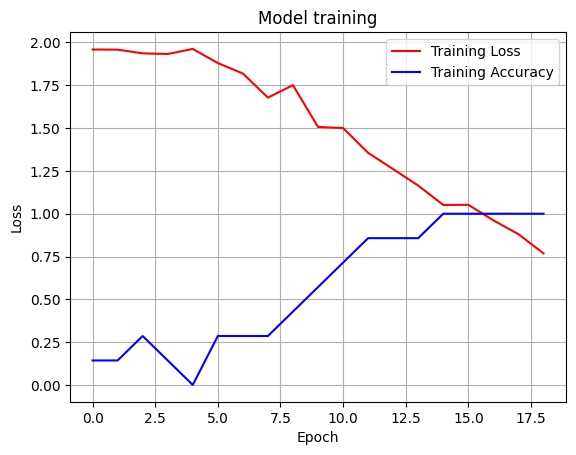

In [30]:
combined_history_stages = {
    'loss' : history_stage_0.history['loss'] + history_stage_1.history['loss'],
    'accuracy' : history_stage_0.history['accuracy'] + history_stage_1.history['accuracy']
}

plt.plot( combined_history_stages['loss'], label='Training Loss', color='red' )
plt.plot( combined_history_stages['accuracy'], label='Training Accuracy', color='blue' )
plt.title( 'Model training' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.legend()
plt.grid()
plt.show()

### Handle intentions and backend logic

In [76]:
def predict_intent( user_input ):
    inputs = tokenizer( user_input, return_tensors='tf', padding=True, truncation=True )

    outputs = model( inputs )
    predicted_label_idx = tf.argmax( outputs.logits, axis=1 ).numpy()[0]

    try:
        predicted_label = label_to_id[ predicted_label_idx ]
    except KeyError as e:
        problematic_key = e.args[0]
        print(f'problematic_key: {problematic_key}')

        return problematic_key


predicted_label = predict_intent( 'Can I close my new account?' )
print( f'predicted intent: { predicted_label }' )

model.save_pretrained( './banking_assistant_model' )        # saving model with its tokenizer
tokenizer.save_pretrained( './banking_assistant_tokenizer' )

problematic_key: 4
predicted intent: 4


('./banking_assistant_tokenizer/tokenizer_config.json',
 './banking_assistant_tokenizer/special_tokens_map.json',
 './banking_assistant_tokenizer/vocab.txt',
 './banking_assistant_tokenizer/added_tokens.json')